In [8]:
%matplotlib inline
import gudhi as gd
from gudhi import hera
from gudhi import representations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import sklearn
from sklearn import manifold
from sklearn_extra.cluster import KMedoids
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import scipy.optimize as spo 
from scipy.optimize import minimize
import kmedoids
import networkx as nx
from networkx import bipartite
import persim

import os
import math
import time

In [2]:

def diag_to_array(data):
    dataset, num_diag = [], len(data["0"].keys())
    for dim in data.keys():
        X = []
        for diag in range(num_diag):
            pers_diag = np.array(data[dim][str(diag)])
            X.append(pers_diag)
        dataset.append(X)
    return dataset

def diag_to_dict(D):
    X = dict()
    for f in D.keys():
        df = diag_to_array(D[f])
        for dim in range(len(df)):
            X[str(dim) + "_" + f] = df[dim]
    return X 

In [3]:
path = "../sklearn-tda/example/3DSeg/"
train_lab  = pd.read_csv(path+"train.csv")
train_diag = diag_to_dict(h5py.File(path+"train_diag.hdf5", "r"))

In [4]:
from sklearn.preprocessing import LabelEncoder

# Size of test set
test_size = 0.95

# Shuffle dataset and pick points for test set
train_num_pts        = train_lab.shape[0]    
perm                 = np.random.RandomState(seed=42).permutation(train_num_pts)
limit                = np.int(test_size * train_num_pts)
test_sub, train_sub  = perm[:limit], perm[limit:]

# Create train and test labels with LabelEncoder from scikit-learn
train_full_labels  = train_lab["part"]
le                 = LabelEncoder()
train_labels       = np.array(le.fit_transform(train_full_labels[train_sub]))
test_labels        = np.array(le.transform(train_full_labels[test_sub]))

# Create train and test sets of persistence diagrams
train_full_diag    = train_diag["1_geodesic"]
train_diag         = [train_full_diag[i] for i in train_sub]
test_diag          = [train_full_diag[i] for i in test_sub]

# Print sizes
train_num_pts, test_num_pts = len(train_sub), len(test_sub)
print("Number of train points = " + str(train_num_pts))
print("Number of test  points = " + str(test_num_pts))
print(perm)

Number of train points = 285
Number of test  points = 5415
[1436  748 4596 ... 5226 5390  860]


/tmp/ipykernel_9589/1934562253.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  limit                = np.int(test_size * train_num_pts)


In [5]:
#return the projection to the diagonal of x
def DiagProj(x):
    return[(x[0]+x[1])/2]*2

In [6]:
def WassersteinProfile(X,Y,p=1):
    Xprime = np.array([DiagProj(y) for y in Y])
    Yprime = np.array([DiagProj(x) for x in X])
    U = np.append(X,Yprime, axis=0)
    V = np.append(Y,Xprime, axis=0)
    #print(U)
    #print(V)
    D1 = sklearn.metrics.pairwise_distances(X,Y, metric= "chebyshev")
    D2 = sklearn.metrics.pairwise_distances(X,Yprime, metric= "chebyshev")
    D3 = sklearn.metrics.pairwise_distances(Xprime, Y, metric= "chebyshev")
    D=np.block([[D1,D2],[D3,np.zeros_like(D1).T]])
    #print(D)
    sortedD = np.sort(D.flatten())
    values = []
    for t in sortedD:
        Dt = np.where(D<=t,0,D)
        #print(Dt)
        row_ind, col_ind = spo.linear_sum_assignment(Dt)
        val = Dt[row_ind, col_ind].sum()
        values.append(val)
        
    return np.array([sortedD,values]).T

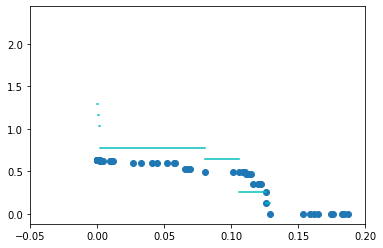

In [19]:
X=train_diag[0]
Y=train_diag[2]
Z=train_diag[1]
wpXY = WassersteinProfile(X,Y)
wpXZ = WassersteinProfile(X,Z)
#wpXY = WassersteinProfile(X,Y)

n_points = len(X)+len(Y)
d_vals = np.linspace(0,n_points,n_points+1)
r_vals = [gd.prokhorov_distance(X, Y, np.array([r])) for r in d_vals]

ts=np.linspace(0,0.2,100)
bp = np.array([gd.bottleneck_profile(X,Y,t) for t in ts])

dB=gd.bottleneck_distance(X,Y)

f, ax = plt.subplots()
ax.scatter(wpXY[:,0], wpXY[:,1])
#ax.scatter(ts, bp*dB)

#ax.scatter(wpXZ[:,0], wpXZ[:,1])
for i in range(1,n_points+1):
    plt.plot((r_vals[i],r_vals[i-1]),(i*dB,i*dB), c='c', label='$D_{X,Y}$')
    
ax.set_xlim((-0.05,0.2))
plt.show()

In [68]:
print(gd.hera.wasserstein_distance(X,Y,order = 1, internal_p=np.inf))
print(gd.bottleneck_distance(X,Y))

0.6343080000000005
0.12911950000000005


In [15]:
r_vals

[0.12911950000000005,
 0.12637999999999994,
 0.10588699999999995,
 0.10588699999999995,
 0.10588699999999995,
 0.08029999999999982,
 0.0024850000000000705,
 0.0021850000000001035,
 0.0010499999999999954,
 0.0005045000000000188,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]